In [2]:
import torch
import matplotlib.pyplot as plt

from config import *

%reload_ext autoreload
%autoreload 2

In [3]:
SPECTRAL_THRESHOLD = CONFIG['SPECTRAL_THRESHOLD']

Load matrix $Q$

In [4]:
mat_q = torch.load(out_path('mat_q.pt'))
mat_q.shape

torch.Size([32064, 472])

In [5]:
mat_q_fft = torch.fft.fft(mat_q, dim=0)
mat_q_fft_mag = torch.abs(mat_q_fft)
mat_q_fft.shape

torch.Size([32064, 472])

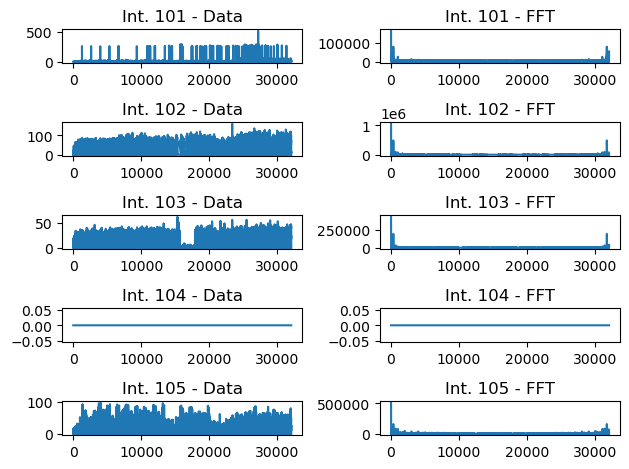

In [6]:
n_plots = 5

def plot_trend_and_fft(data, fft_mag):
    figure, axis = plt.subplots(n_plots, 2)

    for plot, inter in enumerate(range(101, 101 + n_plots)):
        axis[plot, 0].plot(data[:, inter])
        axis[plot, 0].set_title(f'Int. {inter} - Data')

        axis[plot, 1].plot(fft_mag[:, inter])
        axis[plot, 1].set_title(f'Int. {inter} - FFT')

    figure.tight_layout()

plot_trend_and_fft(mat_q, mat_q_fft_mag)

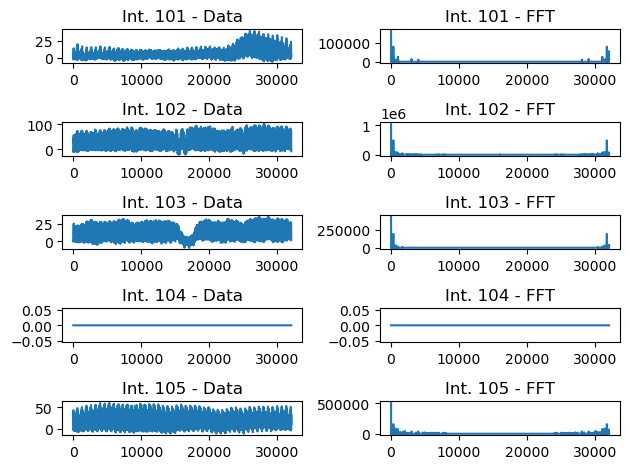

In [7]:
mat_q_trend_fft = mat_q_fft.clone()
mat_q_trend_fft[mat_q_fft_mag < SPECTRAL_THRESHOLD] = 0.0
mat_q_trend_fft_mag = torch.abs(mat_q_trend_fft)

mat_q_trend = torch.fft.ifft(mat_q_trend_fft, dim=0)
torch.save(mat_q_trend, out_path('mat_q_trend.pt'))

plot_trend_and_fft(torch.real(mat_q_trend), mat_q_trend_fft_mag)

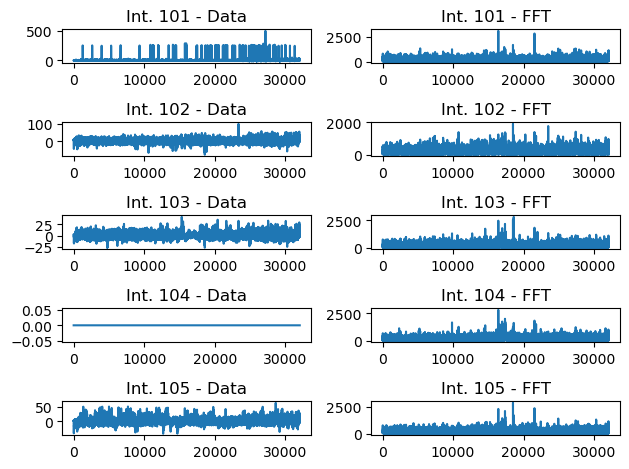

In [8]:
mat_q_resid = mat_q - mat_q_trend
torch.save(mat_q_resid, out_path('mat_q_resid.pt'))

mat_q_resid_fft_mag = torch.abs(torch.fft.fft(mat_q_resid, dim=1))
plot_trend_and_fft(torch.real(mat_q_resid), mat_q_resid_fft_mag)